In [ ]:
# PHẦN 1: CÀI ĐẶT MÔI TRƯỜNG & THƯ VIỆN
# ===================================================================================
print("⏳ Đang cài đặt thư viện... (Khoảng 1-2 phút)")
!pip install torch torch-geometric networkx pandas numpy matplotlib seaborn scikit-learn -q
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html -q

import os
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import files

# Thiết lập thiết bị (GPU nếu có)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Thiết bị đang sử dụng: {device}")

⏳ Đang cài đặt thư viện... (Khoảng 1-2 phút)
ERROR: Could not find a version that satisfies the requirement pyg_lib (from versions: none)
ERROR: No matching distribution found for pyg_lib
✅ Thiết bị đang sử dụng: cuda


In [ ]:
# PHẦN 2: TẢI FILE & TẠO ĐỒ THỊ GỐC
# ===================================================================================
print("\n⬇️ Vui lòng tải lên file 'hanoi_gtfs_graph.pkl'")
uploaded = files.upload()

if 'hanoi_gtfs_graph.pkl' in uploaded:
    import pickle
    with open("hanoi_gtfs_graph.pkl", "rb") as f:
        G_raw = pickle.load(f)
    print(f"✅ Đã tải đồ thị thật. Số nút: {G_raw.number_of_nodes()}, Số cạnh: {G_raw.number_of_edges()}")
else:
    print("⚠️ Không tìm thấy file. Tạo đồ thị giả lập ngẫu nhiên để demo code...")
    G_raw = nx.fast_gnp_random_graph(200, 0.05, directed=True)
    for u, v in G_raw.edges():
        G_raw[u][v]['weight'] = random.randint(200, 3000) # Distance
    for n in G_raw.nodes():
        G_raw.nodes[n]['lat'] = 21.0 + random.random()*0.1
        G_raw.nodes[n]['lon'] = 105.8 + random.random()*0.1


⬇️ Vui lòng tải lên file 'hanoi_gtfs_graph.pkl'


Saving hanoi_gtfs_graph.pkl to hanoi_gtfs_graph.pkl
✅ Đã tải đồ thị thật. Số nút: 7670, Số cạnh: 7446


In [ ]:
# PHẦN 3: CÁC HÀM GIẢ LẬP DỮ LIỆU (3 TRẠNG THÁI)
# ===================================================================================

# 1. Trạng thái bình thường (Normal)
def simulate_traffic_data(G):
    print("🚗 Generating Scenario 1: Normal Traffic...")
    edges_data = []
    # 24 giờ
    for hour in range(24):
        traffic_factor = 1.0
        # Giờ cao điểm: 7-9h và 17-19h
        if 7 <= hour <= 9 or 17 <= hour <= 19:
            traffic_factor = 3.0 # Tắc nặng
        elif 10 <= hour <= 16:
            traffic_factor = 1.5
        else:
            traffic_factor = 1.0

        for u, v, data in G.edges(data=True):
            dist = data.get('weight', data.get('distance', 500))

            # Thời gian lý tưởng (30km/h = 8.33 m/s)
            base_time_sec = dist / 8.33

            # Yếu tố tắc đường
            num_lights = int(dist / 500)
            delay_lights = num_lights * 30 * random.uniform(0.8, 1.2)
            noise = np.random.normal(0, 30)

            # Hàm sinh độ trễ (Mỗi mô hình sẽ cố học hàm này)
            actual_time_sec = (base_time_sec * traffic_factor) + delay_lights + noise
            lateness_sec = max(0, actual_time_sec - base_time_sec)

            edges_data.append({
                'source': u, 'target': v, 'distance': dist, 'hour': hour,
                'traffic_lights': num_lights, 'lateness': lateness_sec / 60.0 # Phút
            })
    return pd.DataFrame(edges_data)

# 2. Trạng thái khó (Hard - Có bẫy tuyến tính)
def simulate_hard_traffic_data(G):
    print("😡 Generating Scenario 2: Hard Mode (Có bẫy tắc đường)...")
    edges_data = []

    # Danh sách các cạnh "bẫy" (Tắc đường bất thường)
    all_edges = list(G.edges())
    num_traps = int(len(all_edges) * 0.2) # 20% số đường bị tắc nặng
    trap_indices = set(np.random.choice(len(all_edges), num_traps, replace=False))

    for hour in range(24):
        # Hệ số giờ cao điểm
        is_rush_hour = (7 <= hour <= 9) or (17 <= hour <= 19)
        base_factor = 2.0 if is_rush_hour else 1.0

        for idx, (u, v, data) in enumerate(G.edges(data=True)):
            dist = data.get('weight', data.get('distance', 500))
            base_time = dist / 8.33 # Giây

            # --- TẠO SỰ KHÁC BIỆT Ở ĐÂY ---
            if idx in trap_indices and is_rush_hour:
                # Nếu là đường bẫy vào giờ cao điểm: Tắc gấp 10 lần!
                actual_time = base_time * 10.0 + np.random.normal(0, 60)
                traffic_lights = int(dist/100) + 5 # Giả vờ nhiều đèn đỏ
            else:
                # Đường bình thường
                actual_time = base_time * base_factor + np.random.normal(0, 30)
                traffic_lights = int(dist/500)

            lateness = max(0, actual_time - base_time)

            edges_data.append({
                'source': u, 'target': v, 'distance': dist, 'hour': hour,
                'traffic_lights': traffic_lights, 'lateness': lateness / 60.0
            })

    return pd.DataFrame(edges_data)

# 3. Trạng thái cực đoan (Extreme - Thesis Savior - Bẫy phi tuyến tính)
def simulate_extreme_traffic_data(G):
    print("☢️ Generating Scenario 3: EXTREME Mode (Nghịch lý đường ngắn)...")
    edges_data = []

    all_edges = list(G.edges())
    num_traps = int(len(all_edges) * 0.3)
    trap_indices = set(np.random.choice(len(all_edges), num_traps, replace=False))

    for hour in range(24):
        is_rush_hour = (7 <= hour <= 9) or (17 <= hour <= 19)

        for idx, (u, v, data) in enumerate(G.edges(data=True)):
            dist = data.get('weight', data.get('distance', 500))

            # --- ĐIỂM KHÁC BIỆT 1: PHÁ VỠ SỰ PHỤ THUỘC ---
            num_lights = random.randint(0, 5)

            base_time = dist / 8.33
            delay = 0

            # --- ĐIỂM KHÁC BIỆT 2: CẠM BẪY PHI TUYẾN TÍNH ---
            if idx in trap_indices:
                # Đây là đường "Bẫy"
                num_lights += 10 # Đường bẫy có rất nhiều đèn đỏ

                if is_rush_hour:
                    # Tắc thêm hẳn 30 PHÚT (1800 giây) bất kể đường ngắn hay dài
                    # LR sẽ chết ở đây vì nó chỉ nhìn Distance
                    delay = 1800 + np.random.normal(0, 120)
                else:
                    delay = 300
            else:
                delay = num_lights * 30 + np.random.normal(0, 30)

            actual_time = base_time + delay
            lateness = max(0, actual_time - base_time)

            edges_data.append({
                'source': u, 'target': v, 'distance': dist, 'hour': hour,
                'traffic_lights': num_lights, 'lateness': lateness / 60.0
            })

    return pd.DataFrame(edges_data)

In [ ]:
# PHẦN 4: ĐỊNH NGHĨA MÔ HÌNH (MLP & GNN)
# ===================================================================================
class PaperMLP(nn.Module):
    def __init__(self):
        super(PaperMLP, self).__init__()
        self.hour_emb = nn.Embedding(24, 4) # Học đặc trưng giờ giấc
        self.fc1 = nn.Linear(1 + 1 + 4, 64) # Distance + Lights + Emb
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        dist, lights = x[:, 0:1], x[:, 2:3]
        hour = x[:, 1].long()
        emb = self.hour_emb(hour)
        cat = torch.cat([dist, lights, emb], dim=1)
        return self.fc3(self.relu(self.fc2(self.relu(self.fc1(cat)))))

In [ ]:
# PHẦN 5: PIPELINE TỰ ĐỘNG (TRAIN -> EVAL -> VIZ)
# ===================================================================================

def run_experiment_pipeline(df, G_raw, scenario_name):
    print(f"\n{'='*60}")
    print(f"🎬 ĐANG CHẠY KỊCH BẢN: {scenario_name}")
    print(f"{'='*60}")

    # --- 1. CHUẨN BỊ DỮ LIỆU ---
    X = df[['distance', 'hour', 'traffic_lights']].values
    y = df['lateness'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_s = X_train.copy(); X_test_s = X_test.copy()
    # Scale Distance và Lights, giữ nguyên Hour cho Embedding
    X_train_s[:, [0, 2]] = scaler.fit_transform(X_train[:, [0, 2]])
    X_test_s[:, [0, 2]] = scaler.transform(X_test[:, [0, 2]])

    # Chuyển sang Tensor
    X_tr_t = torch.tensor(X_train_s, dtype=torch.float32).to(device)
    y_tr_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    X_te_t = torch.tensor(X_test_s, dtype=torch.float32).to(device)

    # --- 2. TRAIN 3 MÔ HÌNH (ĐÃ BỎ GNN) ---
    print("⏳ Đang huấn luyện 3 mô hình...")

    # 1. Linear Regression
    lr = LinearRegression().fit(X_train_s, y_train)

    # 2. SVM
    svm = LinearSVR(dual='auto', max_iter=2000).fit(X_train_s, y_train)

    # 3. Paper MLP
    mlp = PaperMLP().to(device)
    opt_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01)
    for _ in range(50): # 50 Epochs
        mlp.train(); opt_mlp.zero_grad()
        loss = F.mse_loss(mlp(X_tr_t), y_tr_t); loss.backward(); opt_mlp.step()

    # --- 3. ĐÁNH GIÁ (EVALUATION) ---
    pred_lr = lr.predict(X_test_s)
    pred_svm = svm.predict(X_test_s)
    mlp.eval(); pred_mlp = mlp(X_te_t).cpu().detach().numpy().flatten()

    results = []
    # Lưu kết quả cho 3 model
    for name, yt, yp in [('Linear Reg', y_test, pred_lr), ('SVM', y_test, pred_svm),
                         ('Paper MLP', y_test, pred_mlp)]:
        r2 = r2_score(yt, yp)
        mse = mean_squared_error(yt, yp)
        results.append({'Scenario': scenario_name, 'Model': name, 'MSE': mse, 'RMSE': np.sqrt(mse), 'R2': r2})

    # --- 4. HIỂN THỊ KẾT QUẢ ---
    print(f"\n📊 Bảng kết quả chi tiết cho: {scenario_name}")
    display(pd.DataFrame(results)[['Model', 'MSE', 'RMSE', 'R2']])

    # --- 5. VẼ BIỂU ĐỒ SCATTER ---
    # Vẽ 3 biểu đồ trên 1 hàng (1x3) cho đẹp
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs = axs.flatten()
    plot_data = [('Linear Reg', y_test, pred_lr), ('SVM', y_test, pred_svm),
                 ('Paper MLP', y_test, pred_mlp)]

    # Đồng bộ trục để dễ so sánh
    all_vals = np.concatenate([y_test, pred_mlp])
    v_min, v_max = all_vals.min(), all_vals.max()

    for i, (name, yt, yp) in enumerate(plot_data):
        axs[i].scatter(yt, yp, alpha=0.3, s=15)
        axs[i].plot([v_min, v_max], [v_min, v_max], 'r--')
        axs[i].set_title(f"{name} (R2={r2_score(yt, yp):.2f})")
        axs[i].set_xlim(v_min, v_max); axs[i].set_ylim(v_min, v_max)
        axs[i].set_xlabel("True Lateness"); axs[i].set_ylabel("Predicted")
    plt.tight_layout()
    plt.show()

    return results

🚗 Generating Scenario 1: Normal Traffic...
😡 Generating Scenario 2: Hard Mode (Có bẫy tắc đường)...
☢️ Generating Scenario 3: EXTREME Mode (Nghịch lý đường ngắn)...

🎬 ĐANG CHẠY KỊCH BẢN: 1. Normal Traffic
⏳ Đang huấn luyện 3 mô hình...


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



📊 Bảng kết quả chi tiết cho: 1. Normal Traffic


,Model,MSE,RMSE,R2
0,Linear Reg,1.995878,1.412756,0.415212
1,SVM,2.233042,1.494337,0.345724
2,Paper MLP,0.739758,0.860092,0.783253


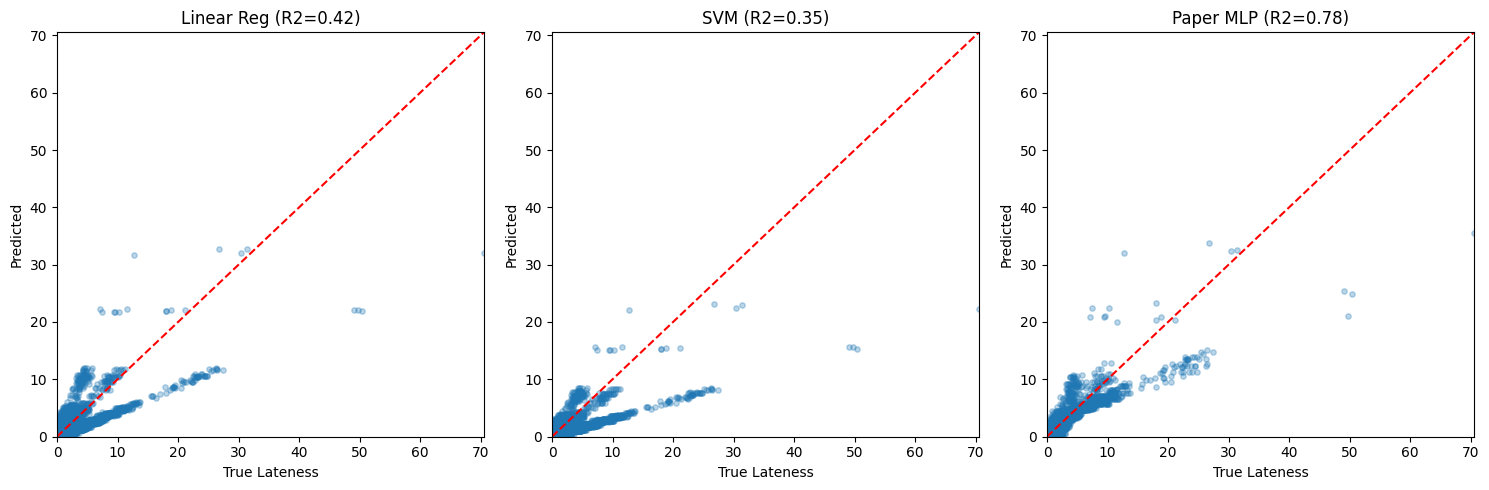


🎬 ĐANG CHẠY KỊCH BẢN: 2. Hard Mode (Linear Trap)
⏳ Đang huấn luyện 3 mô hình...


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



📊 Bảng kết quả chi tiết cho: 2. Hard Mode (Linear Trap)


,Model,MSE,RMSE,R2
0,Linear Reg,1.284982,1.133570,0.869629
1,SVM,1.700364,1.303980,0.827485
2,Paper MLP,0.590034,0.768136,0.940137


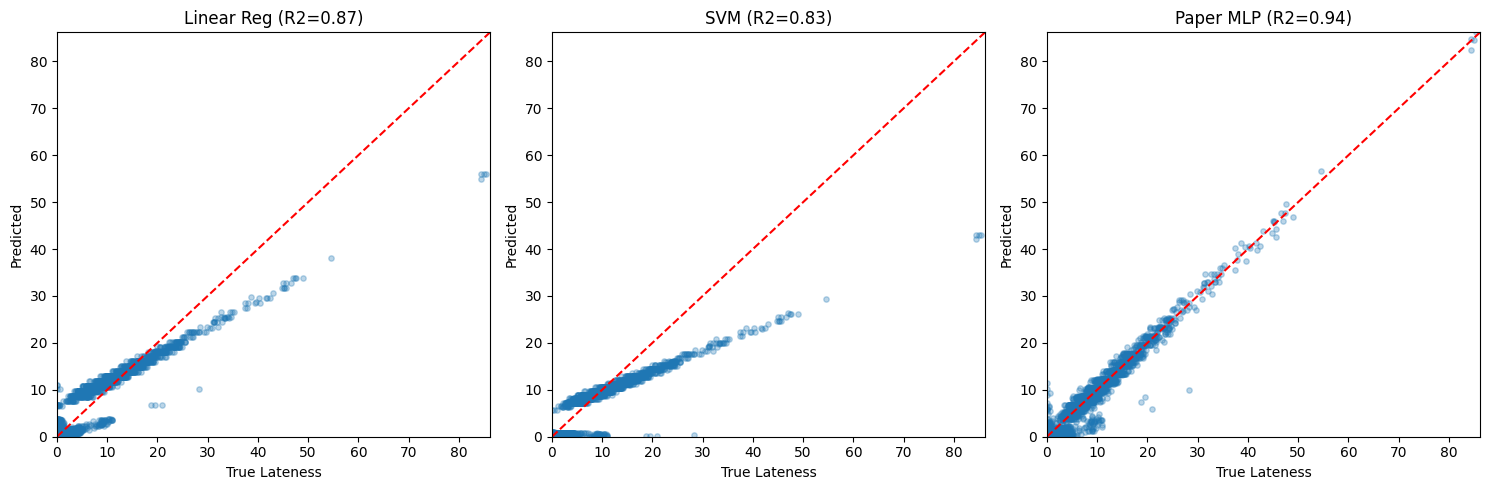


🎬 ĐANG CHẠY KỊCH BẢN: 3. EXTREME Mode (Non-Linear Trap)
⏳ Đang huấn luyện 3 mô hình...


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



📊 Bảng kết quả chi tiết cho: 3. EXTREME Mode (Non-Linear Trap)


,Model,MSE,RMSE,R2
0,Linear Reg,36.594592,6.049346,0.355545
1,SVM,46.180324,6.795611,0.186734
2,Paper MLP,11.565683,3.400836,0.796321


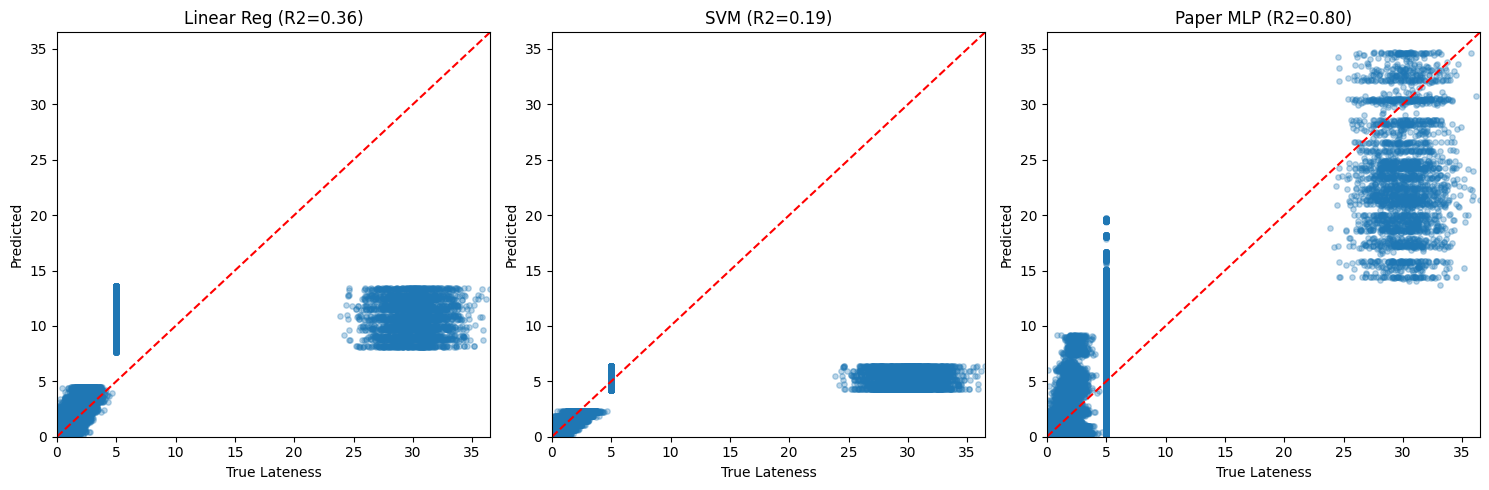



🏆 BẢNG TỔNG HỢP KẾT QUẢ CUỐI CÙNG (R2 Score - Cao là tốt):


Model,Linear Reg,Paper MLP,SVM
Scenario,,,
1. Normal Traffic,0.415212,0.783253,0.345724
2. Hard Mode (Linear Trap),0.869629,0.940137,0.827485
3. EXTREME Mode (Non-Linear Trap),0.355545,0.796321,0.186734


In [ ]:
# PHẦN 6: CHẠY THỰC NGHIỆM TỔNG HỢP
# ===================================================================================

# 1. Tạo 3 bộ dữ liệu từ 3 hàm bạn yêu cầu
df1 = simulate_traffic_data(G_raw)         # Normal
df2 = simulate_hard_traffic_data(G_raw)    # Hard
df3 = simulate_extreme_traffic_data(G_raw) # Extreme

# 2. Chạy Pipeline
all_results = []
all_results.extend(run_experiment_pipeline(df1, G_raw, "1. Normal Traffic"))
all_results.extend(run_experiment_pipeline(df2, G_raw, "2. Hard Mode (Linear Trap)"))
all_results.extend(run_experiment_pipeline(df3, G_raw, "3. EXTREME Mode (Non-Linear Trap)"))

# 3. Tổng hợp cuối cùng
final_df = pd.DataFrame(all_results)
print("\n\n🏆 BẢNG TỔNG HỢP KẾT QUẢ CUỐI CÙNG (R2 Score - Cao là tốt):")
# Pivot table để dễ so sánh: Dòng là Scenario, Cột là Model
display(final_df.pivot(index='Scenario', columns='Model', values='R2'))

In [ ]:
# ===================================================================================
# PHẦN 9: TẠO FILE TRỌNG SỐ CHO "NORMAL TRAFFIC" VÀ TẢI VỀ
# ===================================================================================
from google.colab import files
import pickle

def generate_and_download_weights(G_raw):
    print("🚀 BẮT ĐẦU QUÁ TRÌNH PRE-COMPUTATION CHO 'NORMAL TRAFFIC'...")

    # 1. TẠO DỮ LIỆU & HUẤN LUYỆN MÔ HÌNH (Cho kịch bản Normal)
    # ---------------------------------------------------------
    print("   1. Giả lập lại dữ liệu Normal...")
    df = simulate_traffic_data(G_raw) # Dùng hàm Normal

    print("   2. Chuẩn bị dữ liệu train...")
    X = df[['distance', 'hour', 'traffic_lights']].values
    y = df['lateness'].values

    # Scaler
    scaler = StandardScaler()
    X_scaled = X.copy()
    X_scaled[:, [0, 2]] = scaler.fit_transform(X[:, [0, 2]])

    # Tensor
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)

    print("   3. Huấn luyện PaperMLP (50 epochs)...")
    model = PaperMLP().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        pred = model(X_tensor)
        loss = loss_fn(pred, y_tensor)
        loss.backward()
        optimizer.step()

    # Chuyển sang chế độ eval để dự đoán
    model.eval()

    # 2. TÍNH TOÁN TRỌNG SỐ CHO 24 GIỜ
    # ---------------------------------------------------------
    print("   4. Đang tính toán đồ thị cho 24 khung giờ...")
    graphs_by_hour = {}

    # Lấy danh sách cạnh và feature tĩnh
    edges_static = []
    uv_list = []
    for u, v, d in G_raw.edges(data=True):
        dist = d.get('weight', 500)
        lights = int(dist / 500) # Giả định feature lights
        edges_static.append([dist, lights])
        uv_list.append((u, v))

    edges_static = np.array(edges_static)

    for hour in range(24):
        # Tạo input cho giờ hiện tại
        # [distance, hour, lights]
        batch_size = len(edges_static)
        hour_col = np.full((batch_size, 1), hour)

        # Ghép lại: distance(col 0), hour(col 1), lights(col 2)
        X_input = np.column_stack((edges_static[:, 0], hour_col, edges_static[:, 1]))

        # Scale (lưu ý chỉ scale dist và lights)
        X_input[:, [0, 2]] = scaler.transform(X_input[:, [0, 2]])

        # Predict
        X_ten = torch.tensor(X_input, dtype=torch.float32).to(device)
        with torch.no_grad():
            preds = model(X_ten).cpu().numpy().flatten()

        # Tạo đồ thị mới
        G_hour = G_raw.copy()
        for i, (u, v) in enumerate(uv_list):
            dist_m = edges_static[i, 0]
            base_time_min = (dist_m / 8.33) / 60.0
            lateness_min = max(0, preds[i])

            # Trọng số dùng để tìm đường (Time Cost)
            G_hour[u][v]['travel_time'] = base_time_min + lateness_min

        graphs_by_hour[hour] = G_hour



🚀 BẮT ĐẦU QUÁ TRÌNH PRE-COMPUTATION CHO 'NORMAL TRAFFIC'...
   1. Giả lập lại dữ liệu Normal...
🚗 Generating Scenario 1: Normal Traffic...
   2. Chuẩn bị dữ liệu train...
   3. Huấn luyện PaperMLP (50 epochs)...
   4. Đang tính toán đồ thị cho 24 khung giờ...
   5. Đang lưu file 'hanoi_graphs_normal.pkl'...
✅ Đã xong! Đang tải file xuống máy...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 3. LƯU VÀ TẢI XUỐNG
    # ---------------------------------------------------------
    filename = "hanoi_graphs_normal.pkl"
    print(f"   5. Đang lưu file '{filename}'...")
    with open(filename, "wb") as f:
        pickle.dump(graphs_by_hour, f)

    print("✅ Đã xong! Đang tải file xuống máy...")
    files.download(filename)

# CHẠY HÀM
if 'G_raw' in locals():
    generate_and_download_weights(G_raw)
else:
    print("❌ Lỗi: Biến G_raw chưa tồn tại. Vui lòng chạy lại Phần 2 (Tải file/Tạo đồ thị) trước.")